# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [67]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [68]:
# Download the data
# if not os.path.exists('/content/aerialseq.npy'):
#     !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O /content/aerialseq.npy
# if not os.path.exists('/content/antseq.npy'):
#     !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O /content/antseq.npy

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


# Q4: Efficient Tracking

## Q4.1: Inverse Composition (15 points)

In [69]:
from scipy.interpolate import RectBivariateSpline

def InverseCompositionAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    # Initial M
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

    # ===== your code here! =====
    i = 0
    delta_p_length = threshold
    p = np.zeros((6,1))

    H = It.shape[0]
    W = It.shape[1]

    xVals = np.arange(0,W,1)
    yVals = np.arange(0,H,1)

    p1 = p[0,0]
    p2 = p[1,0]
    p3 = p[2,0]
    p4 = p[3,0]
    p5 = p[4,0]
    p6 = p[5,0]
    M = np.array([[1 + p1, p2, p3], [p4, 1 + p5, p6], [0, 0, 1]]) # (3,3) and therefore invertible
    Minv = np.linalg.inv(M)

    yGrid, xGrid = np.meshgrid(yVals,xVals,indexing="ij")
    xGrid_flat = xGrid.ravel()
    yGrid_flat = yGrid.ravel()
    oneGrid_flat = np.zeros_like(xGrid_flat) + 1
    points_flat = np.vstack((xGrid_flat,yGrid_flat,oneGrid_flat)) # [x_list;y_list;1_list]

    points_flat_tf = M@points_flat
    xGrid_tf_flat = points_flat_tf[0,:]
    yGrid_tf_flat = points_flat_tf[1,:]
    xGrid_tf = np.reshape(xGrid_tf_flat,(H,W))
    yGrid_tf = np.reshape(yGrid_tf_flat,(H,W))

    rbs_TW = RectBivariateSpline(yVals,xVals,It)
    TW = rbs_TW.ev(xGrid_tf,yGrid_tf)

    T_t = np.copy(It)
    T_t_flat = T_t.ravel()

    gradientT_X = np.gradient(T_t,axis=1)
    gradientT_Y = np.gradient(T_t,axis=0)
    gradientT_X_flat = gradientT_X.ravel()
    gradientT_Y_flat = gradientT_Y.ravel()
    gradientT_all = np.vstack((gradientT_X_flat,gradientT_Y_flat))

    xVals = np.arange(0,W,1)
    yVals = np.arange(0,H,1)

    yGrid, xGrid = np.meshgrid(yVals,xVals,indexing="ij")
    xGrid_flat = xGrid.ravel()
    yGrid_flat = yGrid.ravel()

    maskX = np.logical_and(xGrid_tf_flat<W,xGrid_tf_flat>=0)
    maskY = np.logical_and(yGrid_tf_flat<H,yGrid_tf_flat>=0)
    maskAll = maskX*maskY

    N = xGrid_flat.size

    gradientX_zeros = np.copy(gradientT_X_flat)
    gradientX_zeros[~maskAll] = 0
    gradientY_zeros = np.copy(gradientT_Y_flat)
    gradientY_zeros[~maskAll] = 0

    A = np.zeros((N,6))
    A[:,0] = gradientX_zeros*xGrid_flat
    A[:,1] = gradientY_zeros*xGrid_flat
    A[:,2] = gradientX_zeros*yGrid_flat
    A[:,3] = gradientY_zeros*yGrid_flat
    A[:,4] = gradientX_zeros*1
    A[:,5] = gradientY_zeros*1


    while (i < num_iters) and (delta_p_length >= threshold):

        points_flat_tf = M@points_flat
        xGrid_tf_flat = points_flat_tf[0,:]
        yGrid_tf_flat = points_flat_tf[1,:]
        xGrid_tf = np.reshape(xGrid_tf_flat,(H,W))
        yGrid_tf = np.reshape(yGrid_tf_flat,(H,W))
        TW = rbs_TW.ev(xGrid_tf,yGrid_tf)
        TW_flat = TW.ravel()

        b = (T_t_flat - TW_flat)
        # print(A.shape)
        # print(b.shape)

        delta_p = np.linalg.lstsq(A,b,rcond=None)[0]
        p = p + delta_p
        delta_p_length = np.square(np.linalg.norm(delta_p,ord=2))

        p1 = p[0,0]
        p2 = p[1,0]
        p3 = p[2,0]
        p4 = p[3,0]
        p5 = p[4,0]
        p6 = p[5,0]
        M = np.array([[1 + p1, p2, p3], [p4, 1 + p5, p6], [0, 0, 1]]) # (3,3) and therefore invertible
        i = i + 1

    # Adjust M to be (2,3) again
    newM = M[0:2,0:3]
    # ===== End of code =====
    return newM

## Debug Q4.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

Text(0.5, 1.0, 'Warped Source image')

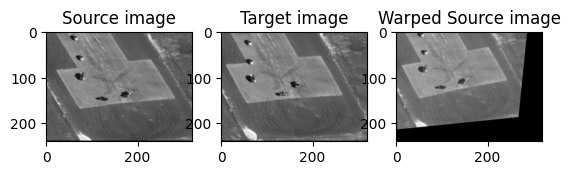

In [70]:
import cv2

num_iters = 100
threshold = 0.01
seq = np.load("data\\aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = InverseCompositionAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')

## Q4.2 Tracking with Inverse Composition (10 points)

Re-use your impplementation in Q3.2 for subtract dominant motion. Just make sure to use InverseCompositionAffine within.

In [71]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)

    mask = np.ones(It.shape, dtype=bool)

    # ===== your code here! =====
    M = InverseCompositionAffine(It, It1, threshold, num_iters)
    warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
    absDiff = np.abs(It1 - warped_It)
    mask1 = absDiff > tolerance
    mask2 = absDiff < np.max(absDiff)*1.0
    mask = mask1*mask2
    # ===== End of code =====

    return mask


Re-use your implementation in Q3.3 for sequence tracking.

In [72]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape

    masks = []
    It = seq[:,:,0]

    # ===== your code here! =====
    for i in tqdm(range(1, seq.shape[2])):
        if (i == seq.shape[2]-1):
            It = seq[:,:,i]
            It1 = seq[:,:,i]
        else:
            It = seq[:,:,i]
            It1 = seq[:,:,i+1]
        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        masks.append(mask)
        # print(mask)
    # ===== End of code =====
    masks = np.stack(masks, axis=2)
    return masks

Track the ant sequence with inverse composition method.


In [73]:
seq = np.load("data\\antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 20
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

  0%|          | 0/124 [00:00<?, ?it/s]

100%|██████████| 124/124 [00:53<00:00,  2.32it/s]


Ant Sequence takes 53.537793 seconds


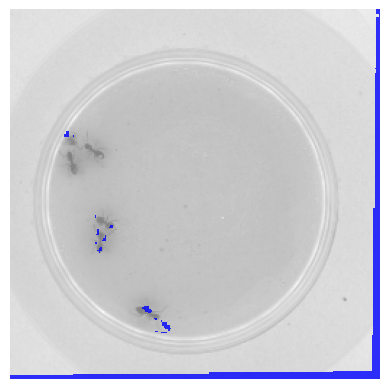

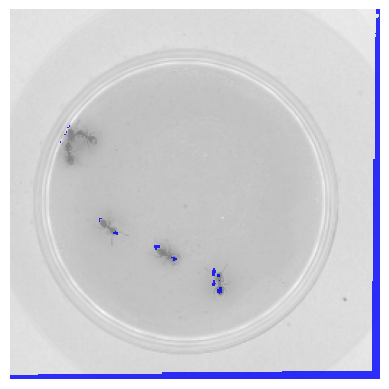

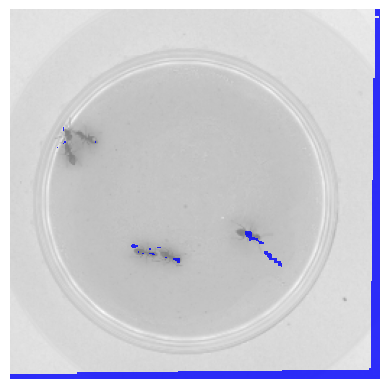

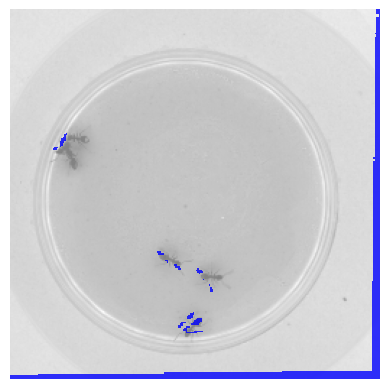

In [74]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')


Track the aerial sequence with inverse composition method.


In [75]:
seq = np.load("data\\aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 20
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAerial Sequence takes %f seconds' % (toc - tic))

100%|██████████| 149/149 [01:05<00:00,  2.26it/s]


Aerial Sequence takes 65.856698 seconds


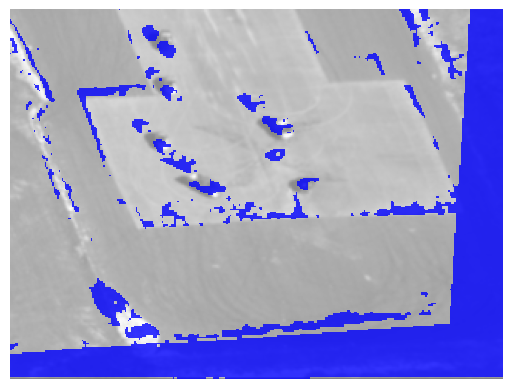

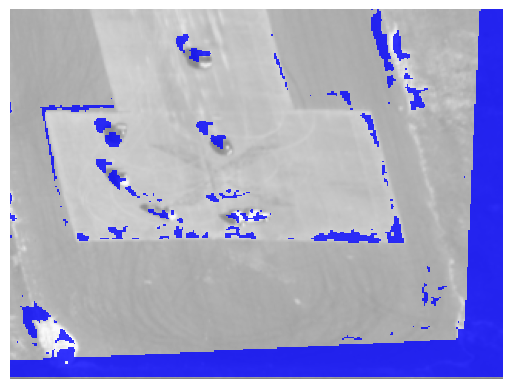

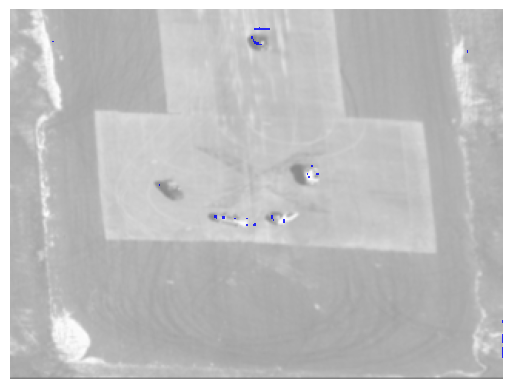

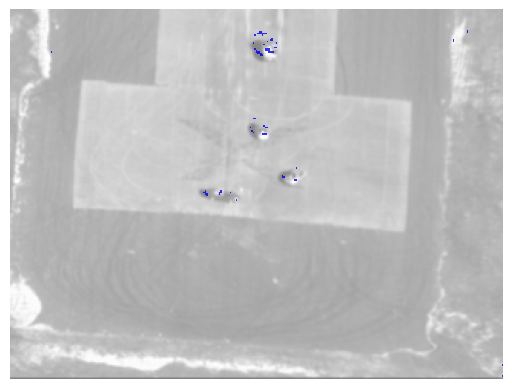

In [76]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')

## Q4.2.1 Compare the runtime of the algorithm using inverse composition (as described in this section) with its runtime without inverse composition (as detailed in the previous section) in the context of the ant and aerial sequences:
===== your answer here! =====

The ant sequence normally took 56 seconds but was decreased to around 53 seconds using the inverse composition method.

The aerial sequence normally took 79 seconds but was decreased to around 66 seconds using the inverse composition method.

===== end of your answer ====

## Q4.2.2 In your own words, please describe briefly why the inverse compositional approach is more computationally efficient than the classical approach:
===== your answer here! =====

You don't have to recompute the Hessian over and over again. For my computation strategy that's equivalent to not having to compute the A matrix over and over again.

===== end of your answer ====